# Unsupervised Clustering of Board Game Reviews

_Ryan Harper_

In [1]:
import random
import numpy as np
from string import punctuation as punct
import matplotlib.pyplot as plt
import seaborn as sns
import os
import operator

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec


from keras.preprocessing.sequence import pad_sequences

# for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
def beep(audio): 
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')

Using TensorFlow backend.


# 1. Import and Clean Data

In [2]:
import pandas as pd

boardgamereviews = pd.read_csv('../data/boardgame/boardgame-comments-english.csv')
boardgamereviews.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
unique_id = boardgamereviews.reviewer_id.unique()
sample_id = random.sample(unique_id.tolist(),3000)
review = boardgamereviews[boardgamereviews['reviewer_id'].isin(sample_id)]

#### _Ratings equal the difference between a user's rating and that user's average rating._

In [3]:
review['rating_normed'] = review.rating - review['rating'].groupby(review['reviewer_id']).transform('mean')
review['rating_normed']= (review['rating_normed']-review['rating_normed'].min())/(review['rating_normed'].max()-review['rating_normed'].min())
# review['estimate'] = review['rating_normed'] + review['rating'].groupby(review['reviewer_id']).transform('mean')

In [4]:
review['rating'] = review['rating'].apply(round)

# 2. Visualize

#### _The ratings appear normalized after reviews are adjusted according to user specific ratings_

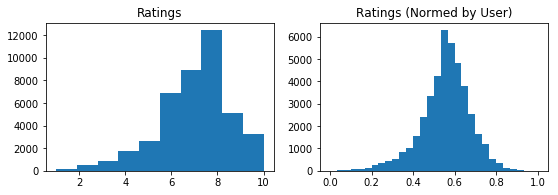

In [5]:
plt.figure(figsize=(9,6))
plt.subplot(2,2,1)
plt.hist(review.rating,bins=10)
plt.title('Ratings')

plt.subplot(2,2,2)
plt.hist(review.rating_normed,bins=30)
plt.title('Ratings (Normed by User)');

# 3. Tokenize

In [6]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)

# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments


comments_train = list(review["comment"].fillna("NAN_WORD").values)

review['token'] = process_comments(comments_train, lower=True)

Processing text dataset


100%|██████████| 42576/42576 [00:01<00:00, 23674.31it/s]


In [7]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 27534 unique tokens


# 5. Vectorize

In [8]:
model = Word2Vec(review['token'], size=100, window=5, min_count=5, workers=16, sg=0, negative=5)
vec_size = model.layer1_size
word_vectors = model.wv

In [9]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 8954


In [10]:
model.wv.most_similar_cosmul(positive=['paper', 'board'], negative=['box'])

[('tacked', 1.0231280326843262),
 ('emphasis', 1.013245940208435),
 ('focused', 1.008711338043213),
 ('fighting', 0.9980025291442871),
 ('market', 0.9818854928016663),
 ('dudes', 0.9785783886909485),
 ('taking', 0.9734194874763489),
 ('territory', 0.970178484916687),
 ('focusing', 0.9645894169807434),
 ('paste', 0.9583916664123535)]

__Cosine Similarity Function__

$$ cos(\theta) = \frac{A \bullet B} {\Vert A \Vert \Vert B \Vert} =  \frac{\sum_{i=1}^n A_i B_i}{\sqrt{ \sum_{i=1}^n A^2} \sqrt{ \sum_{i=1}^n B^2}} $$

_Version A. Raw Code_

#### _Used the cosine similarity function to check common words. 'Easy' and 'Simple' appear to be much more similar than 'Cat'.<br> <br>A good sign that the vectorization worked!_

# 4. Vocab Scoring

# 4. Word Embedding

In [11]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [12]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [13]:
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in review['token']]

In [14]:
# pad
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
y = pd.get_dummies(review['rating']).values

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (42576, 200)
Shape of label tensor: (42576, 10)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [16]:
target_categorical_unique = len(review['rating'].unique())

In [17]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    

# 5. Models

In [18]:
from keras.layers import Dense, Input, CuDNNLSTM, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [19]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

In [20]:
# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

In [21]:
embedded_sequences = wv_layer(comment_input)

In [22]:
# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

In [23]:
# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(target_categorical_unique, activation='sigmoid')(x)

In [24]:
# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=['categorical_accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          895400    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total para

In [26]:
hist = model.fit(X_train, y_train, validation_split=0.2,
                 epochs=20, verbose=1,batch_size=256, shuffle=True)

Train on 20436 samples, validate on 5109 samples
Epoch 1/20
20436/20436 [==============================] - 69s 3ms/step - loss: 2.2645 - categorical_accuracy: 0.1519 - val_loss: 2.0234 - val_categorical_accuracy: 0.2642
Epoch 2/20
20436/20436 [==============================] - 66s 3ms/step - loss: 1.9302 - categorical_accuracy: 0.2566 - val_loss: 1.9212 - val_categorical_accuracy: 0.2560
Epoch 3/20
20436/20436 [==============================] - 65s 3ms/step - loss: 1.8237 - categorical_accuracy: 0.2912 - val_loss: 1.8300 - val_categorical_accuracy: 0.2893
Epoch 4/20
20436/20436 [==============================] - 63s 3ms/step - loss: 1.7921 - categorical_accuracy: 0.3010 - val_loss: 1.7798 - val_categorical_accuracy: 0.3104
Epoch 5/20
20436/20436 [==============================] - 65s 3ms/step - loss: 1.7646 - categorical_accuracy: 0.3082 - val_loss: 1.7678 - val_categorical_accuracy: 0.3087
Epoch 6/20
20436/20436 [==============================] - 66s 3ms/step - loss: 1.7467 - categori

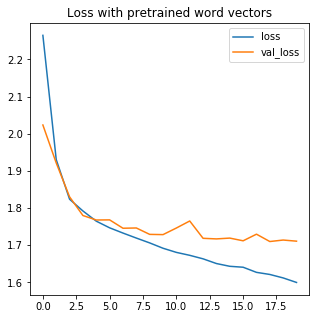

In [27]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(5,5));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors")
plt.legend()
plt.show();

In [29]:
score = model.evaluate(X_test, y_test, verbose=0)

InvalidArgumentError: indices[15,182] = 8954 is not in [0, 8954)
	 [[Node: embedding_1/GatherV2 = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@spatial_dropout1d_1/cond/Switch_1"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_1/embeddings/read, _arg_input_1_0_2, bidirectional_1/TensorArrayUnstack/range/start)]]

Caused by op 'embedding_1/GatherV2', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-1dd6a6caf8fe>", line 1, in <module>
    embedded_sequences = wv_layer(comment_input)
  File "/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/keras/layers/embeddings.py", line 138, in call
    out = K.gather(self.embeddings, inputs)
  File "/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1215, in gather
    return tf.gather(reference, indices)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2659, in gather
    return gen_array_ops.gather_v2(params, indices, axis, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3142, in gather_v2
    "GatherV2", params=params, indices=indices, axis=axis, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): indices[15,182] = 8954 is not in [0, 8954)
	 [[Node: embedding_1/GatherV2 = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@spatial_dropout1d_1/cond/Switch_1"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_1/embeddings/read, _arg_input_1_0_2, bidirectional_1/TensorArrayUnstack/range/start)]]


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
predict = model.predict(X_test)

In [ ]:
def convert_to_one(p):
    new_p =[]
    for values in p:
        l = []
        max_index,_ = max(enumerate(values), key=operator.itemgetter(1))

        for m in range(len(values)):
            if m!=max_index:
                l.append(0)
            else:
                l.append(1)
        new_p.append(l)
        
    return new_p

In [ ]:
from keras.backend import argmax as kargmax
y_predict = np.argmax(predict,axis=1)
y_actual = np.argmax(y_test,axis=1)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_actual[0:150],color='b')
plt.plot(y_predict[0:150],color='r')
plt.title('Neural Network Ratings Prediction')
plt.legend(['Actual','Predicted'])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y, y_pred, title):
    # rating levels
    ratings = list(range(1,11))

    # generate confusion matrix
    cm = confusion_matrix(y, y_pred)

    # normalize matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plot matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.magma)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(ratings))
    plt.xticks(tick_marks, ratings, rotation=45)
    plt.yticks(tick_marks, ratings)
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Actual rating')
    plt.xlabel('Predicted rating');

In [ ]:
plot_confusion(y_actual,y_predict,'LSTM NN')

## _Root Mean Squared Error_

$$ RMSE_{y} =  \sqrt{\frac{\sum_{i=1}^n {(\hat{y}_{i}- y_{i})}^2}{N}} $$

In [ ]:
RMSE = np.sqrt(np.sum(np.square(np.subtract(y_predict,y_actual)))/len(y_actual))
# print('Root Mean Squared Error: {}'.format(RMSE))

In [ ]:
print(RMSE)